In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy.stats import zscore

file_path = "https://api.github.com/repos/AAI500TeamProject/thementalists-project/contents/Dataset/MentalHealth"
response = requests.get(file_path)
files = response.json()

dataframes = {}

#find columns with missing data
for file in files:
    if file['name'].endswith('.csv'):
        file_name = file['name']
        raw_url = file['download_url']  # direct raw file URL
        dataframes[file_name] = pd.read_csv(raw_url)

        print(f"{file_name} missing values: \n {dataframes[file_name].isnull().sum()}")

        dataframes[file_name] = dataframes[file_name].drop(columns=['Code']) #drop column "Code" because we have column "Entity" and "Code" won't effect the training process

        keywords = ['Schizophrenia', 'Depressive', 'Anxiety', 'Bipolar', 'Eating']
        column_mapping = {}
        for col in  dataframes[file_name].columns:
            for keyword in keywords:
                if keyword.lower() in col.lower():
                    column_mapping[col] = keyword
                    break 

    dataframes[file_name] = dataframes[file_name].rename(columns=column_mapping)
    print(f"{file_name} \n {dataframes[file_name]}")



1- mental-illnesses-prevalence.csv missing values: 
 Entity                                                                                 0
Code                                                                                 270
Year                                                                                   0
Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized      0
Depressive disorders (share of population) - Sex: Both - Age: Age-standardized         0
Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized            0
Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized            0
Eating disorders (share of population) - Sex: Both - Age: Age-standardized             0
dtype: int64
1- mental-illnesses-prevalence.csv 
            Entity  Year  Schizophrenia  Depressive   Anxiety   Bipolar  \
0     Afghanistan  1990       0.223206    4.996118  4.713314  0.703023   
1     Afghanistan  1991       0.22245

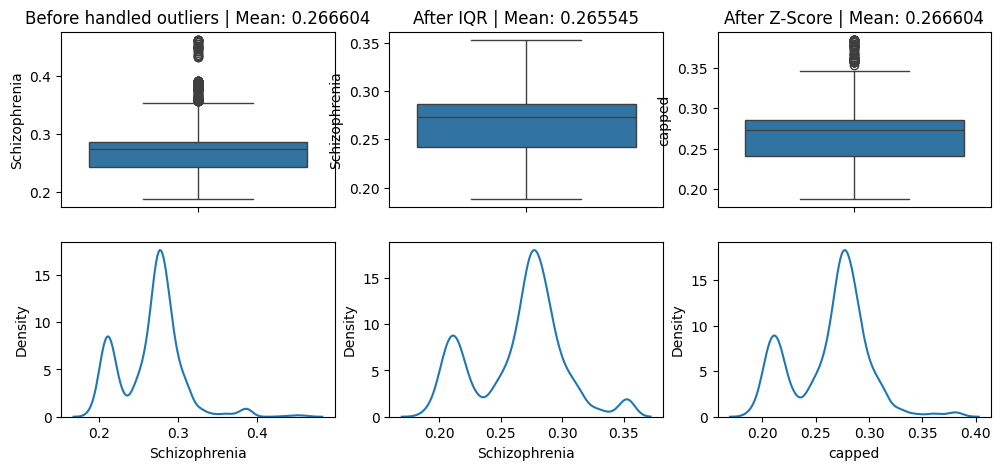

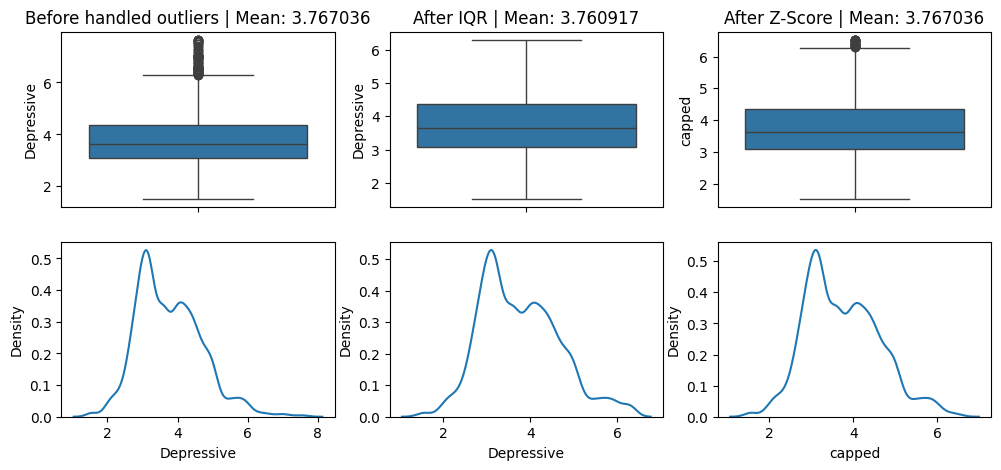

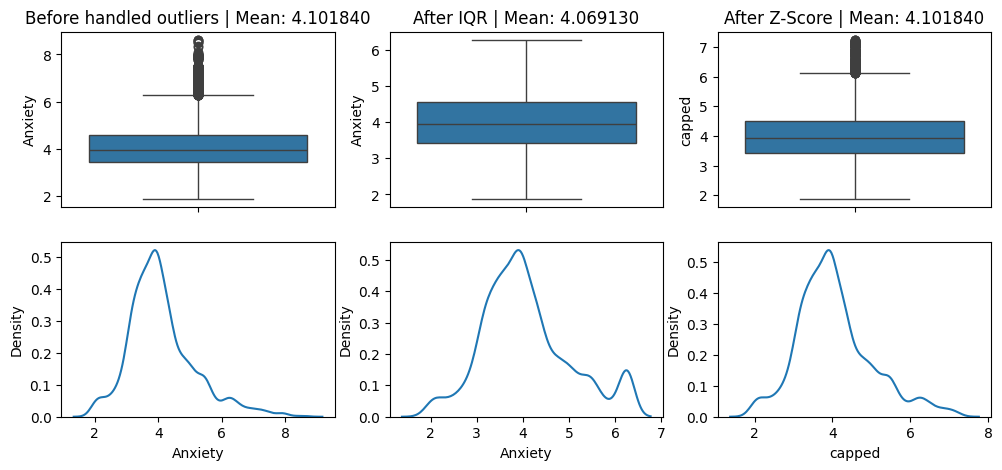

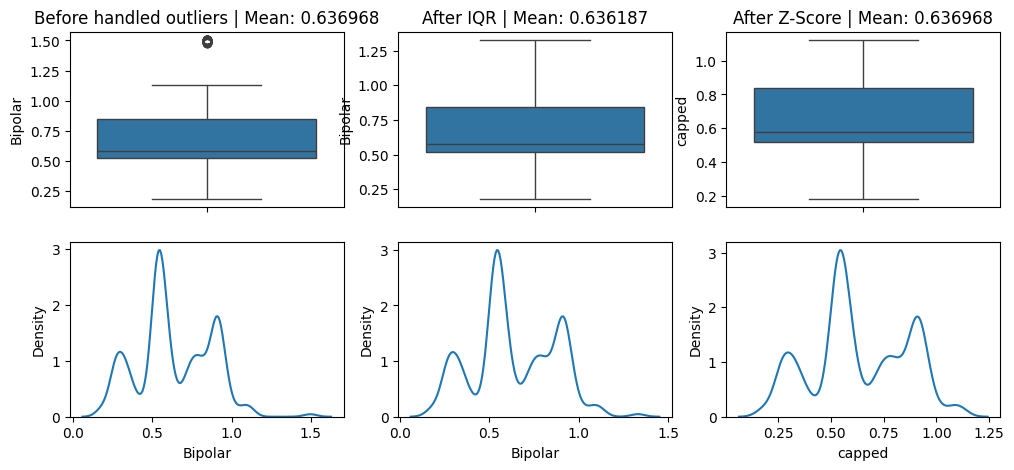

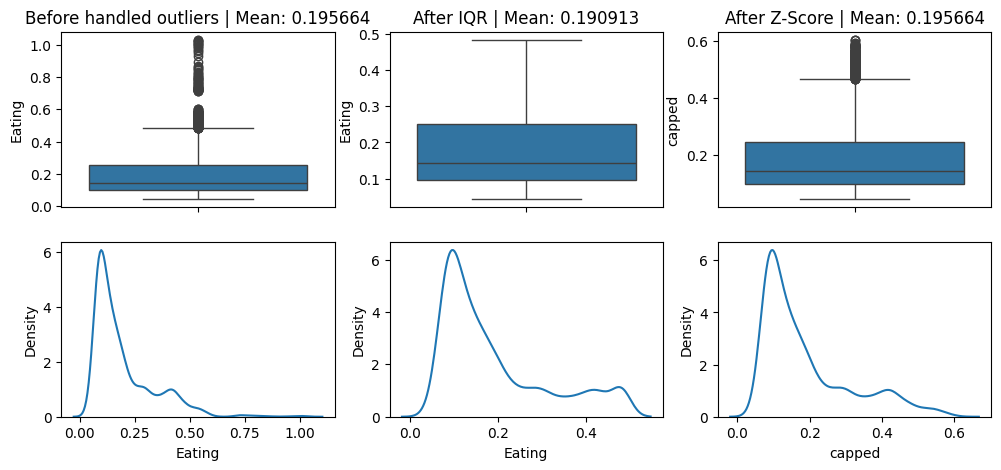

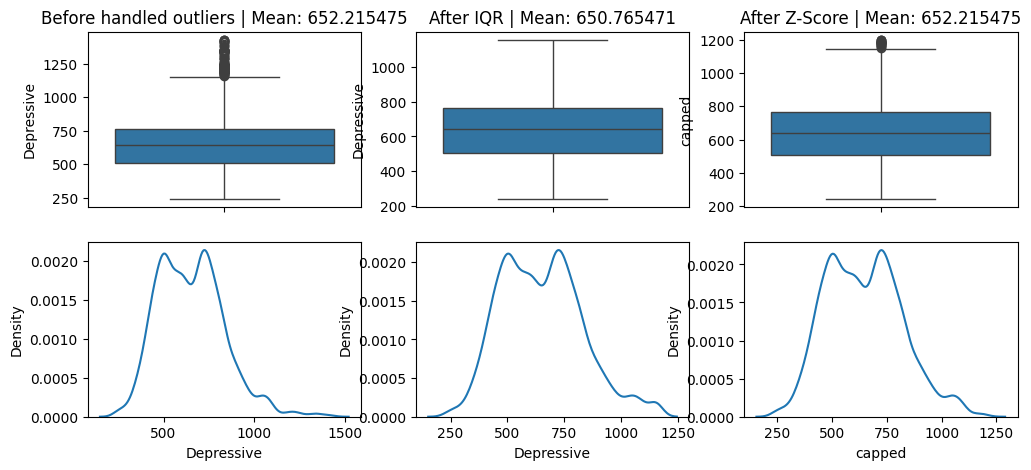

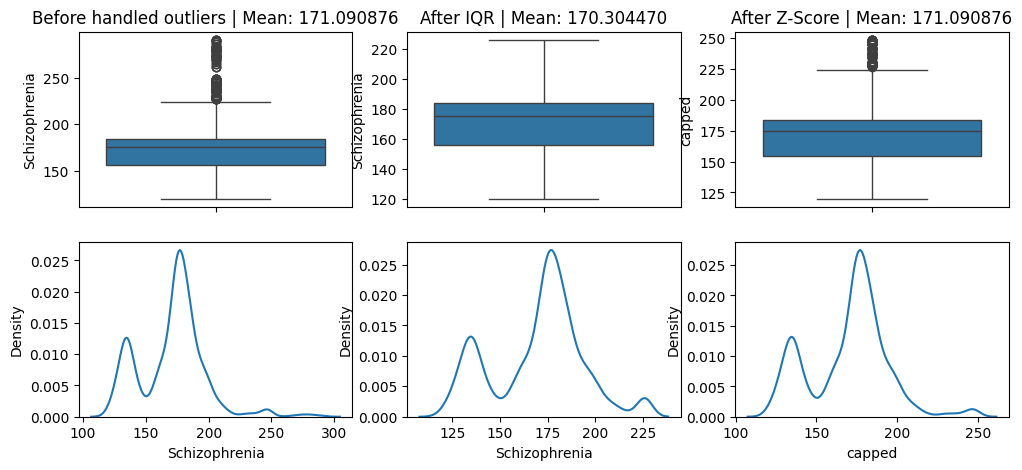

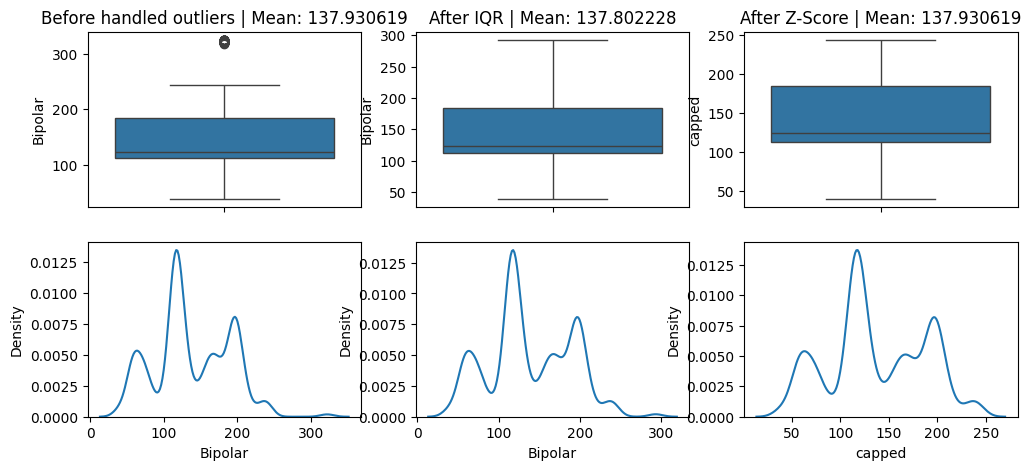

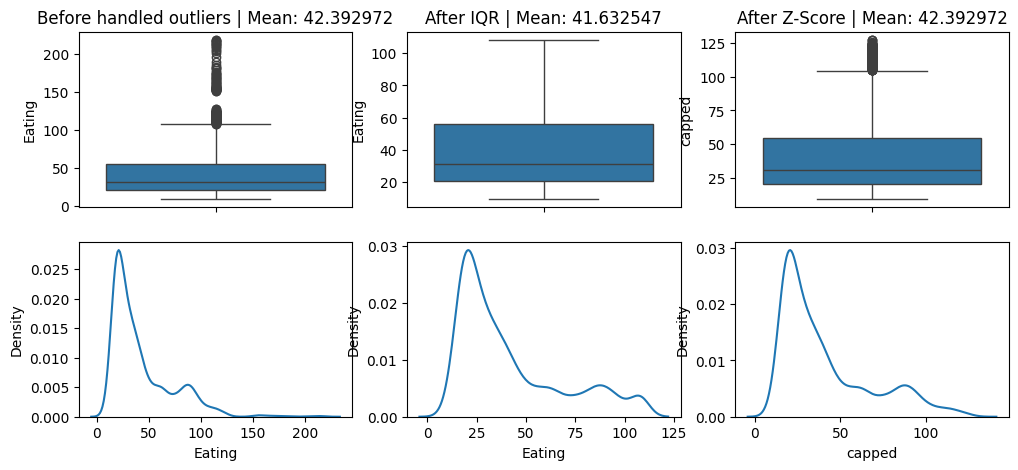

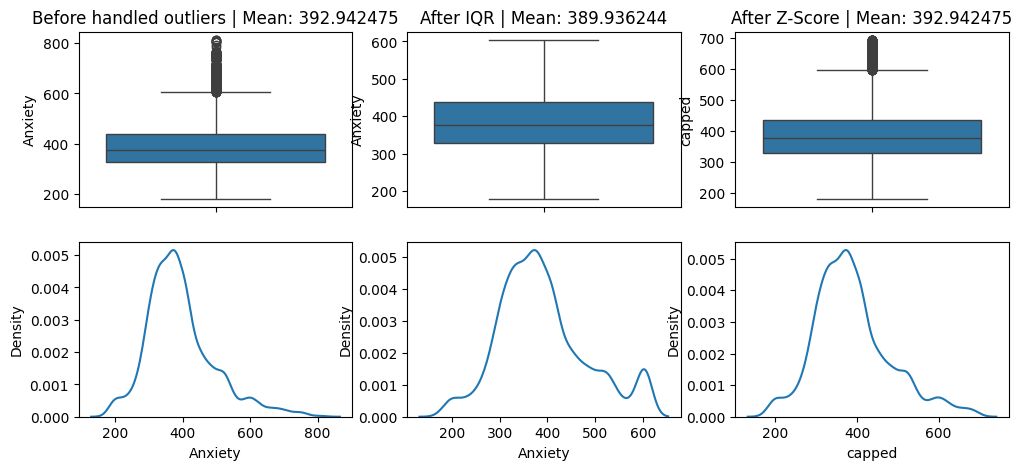

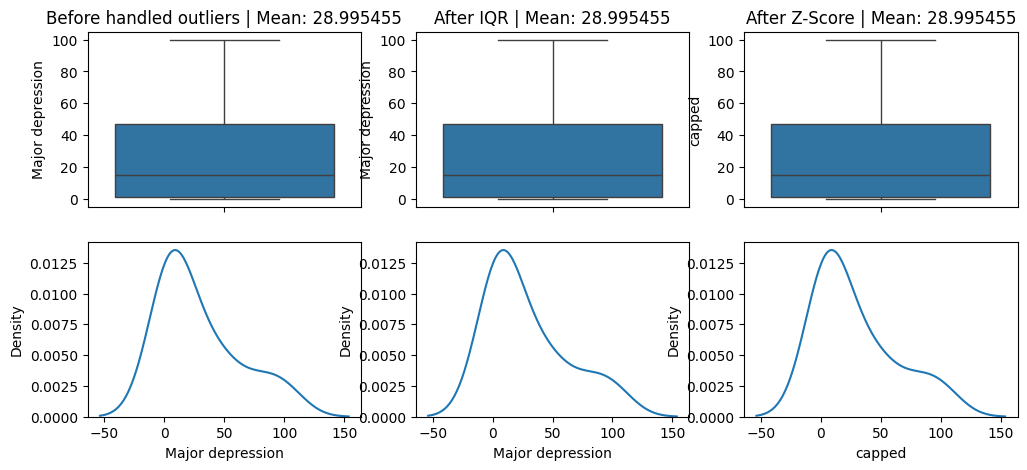

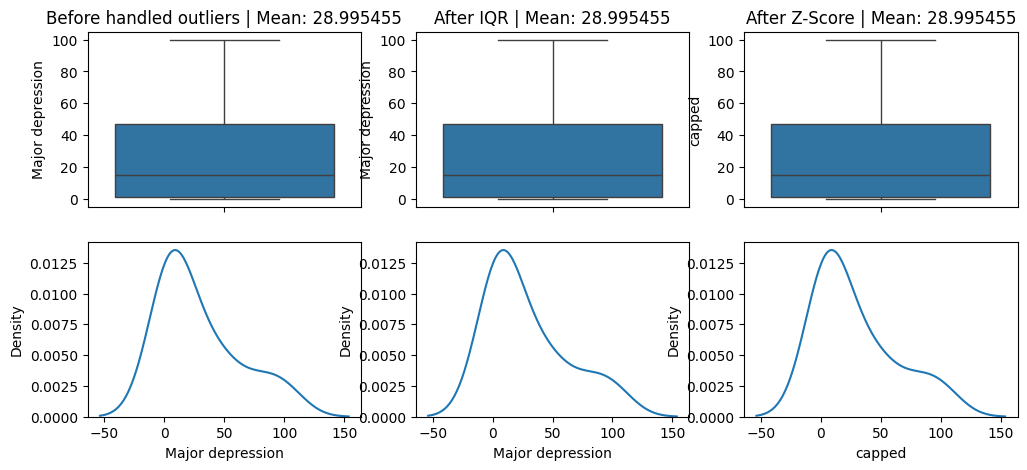

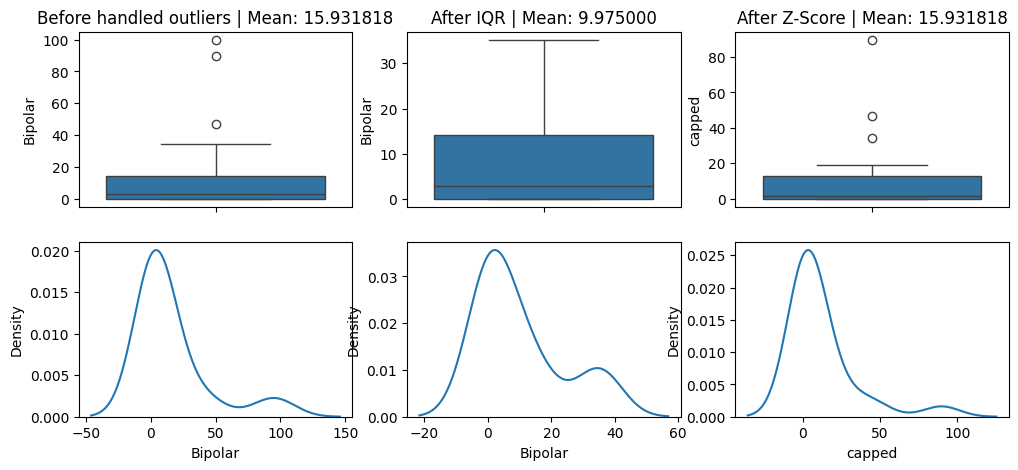

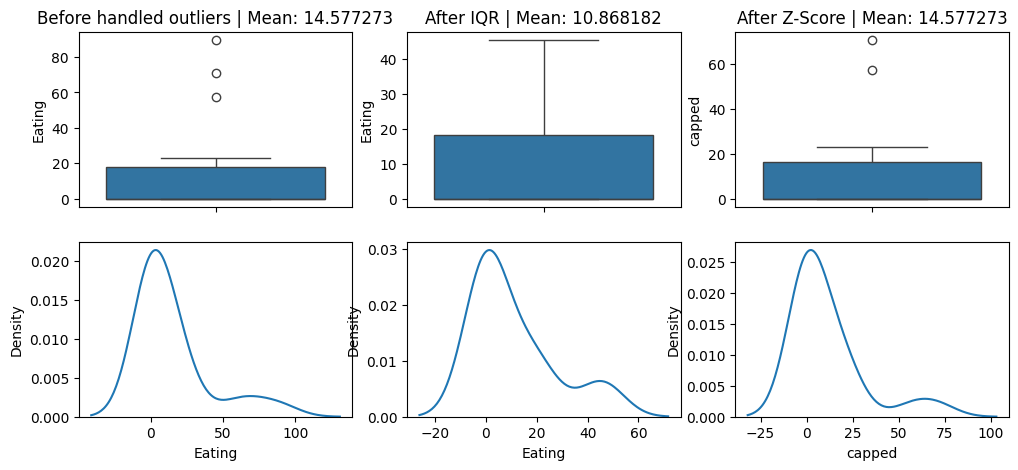

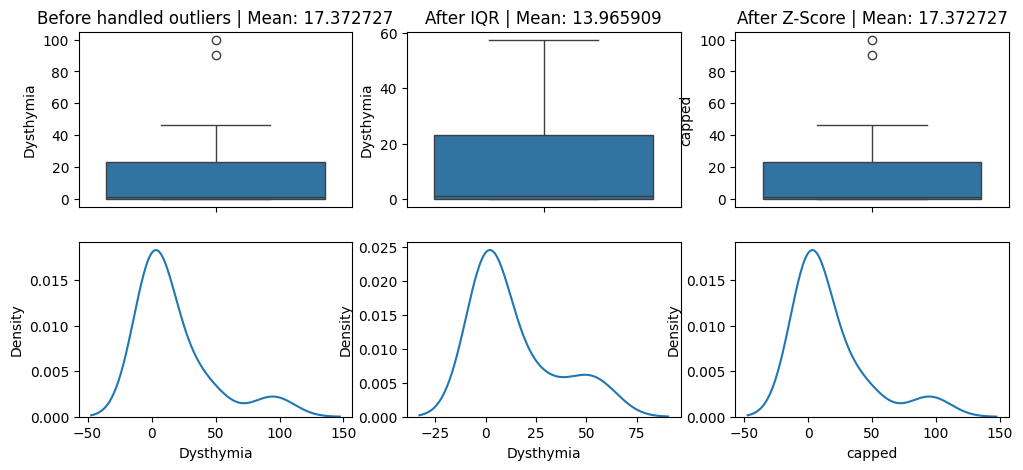

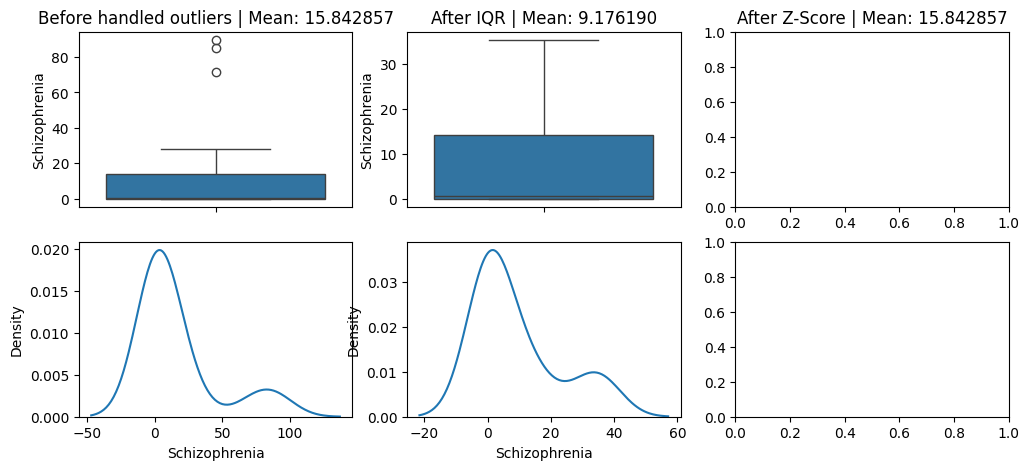

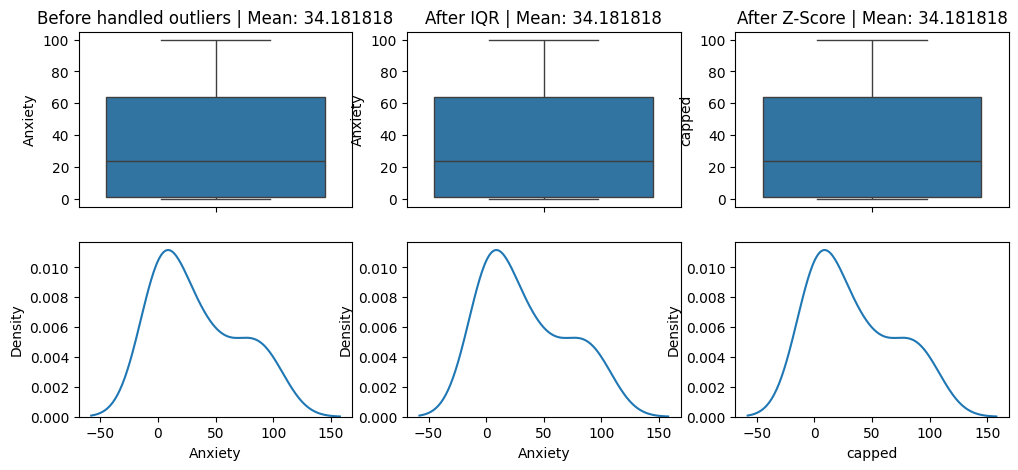

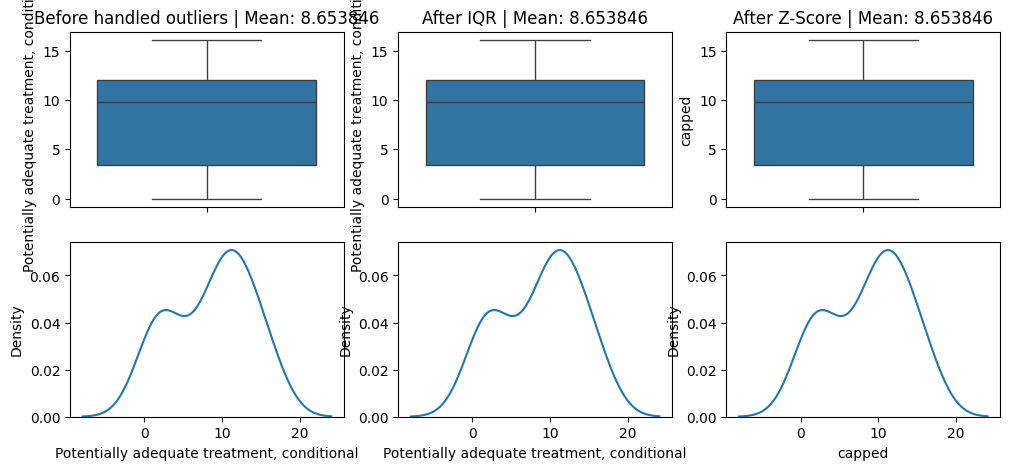

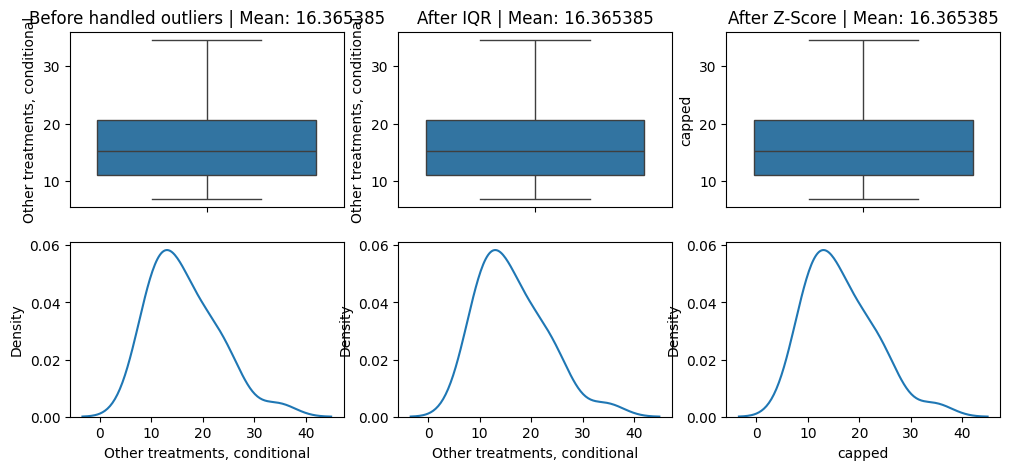

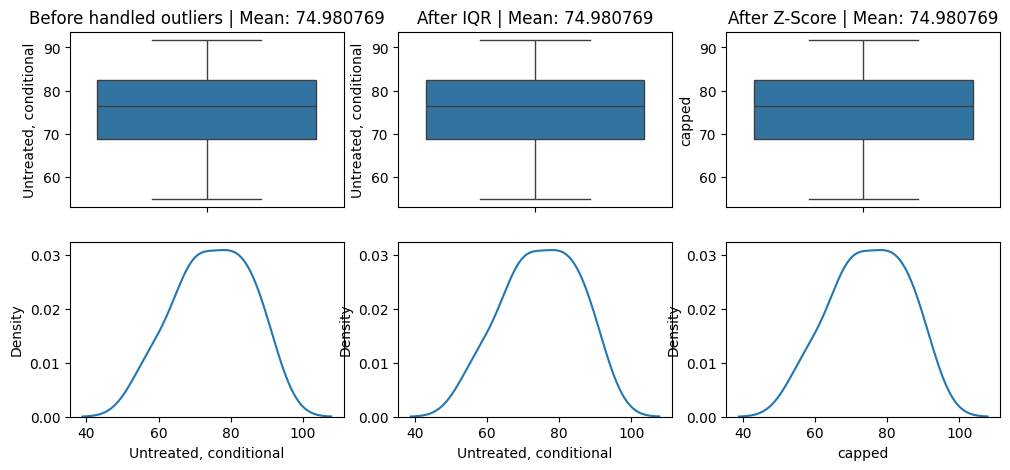

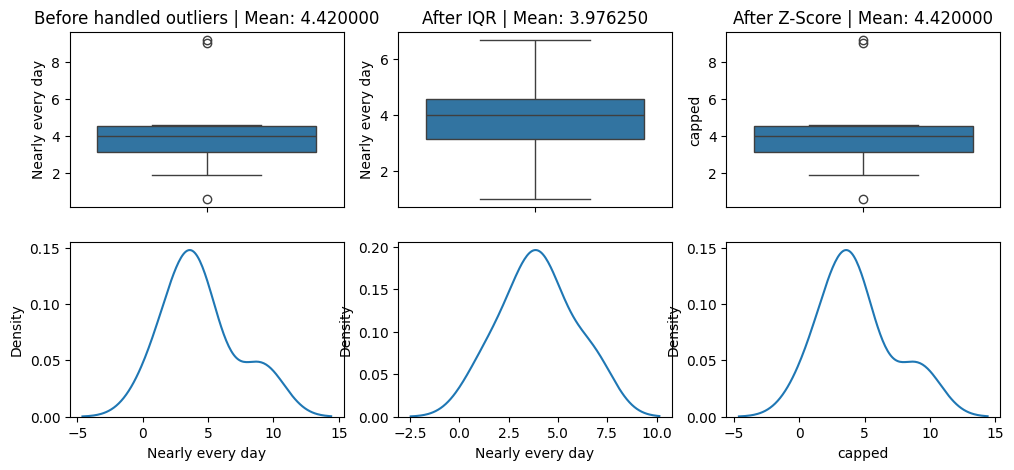

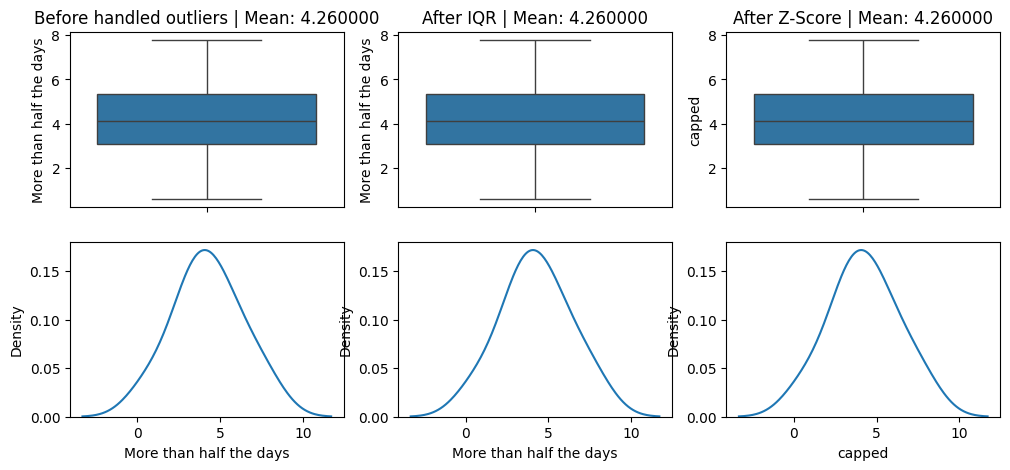

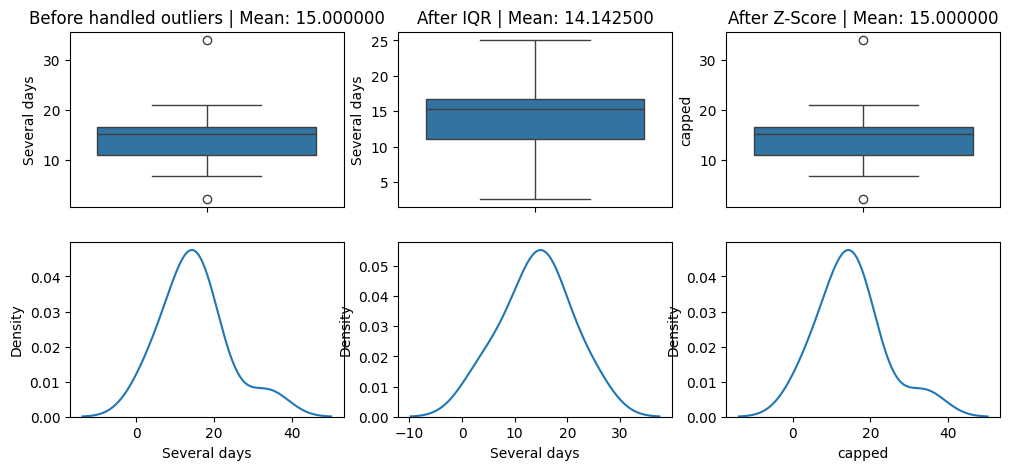

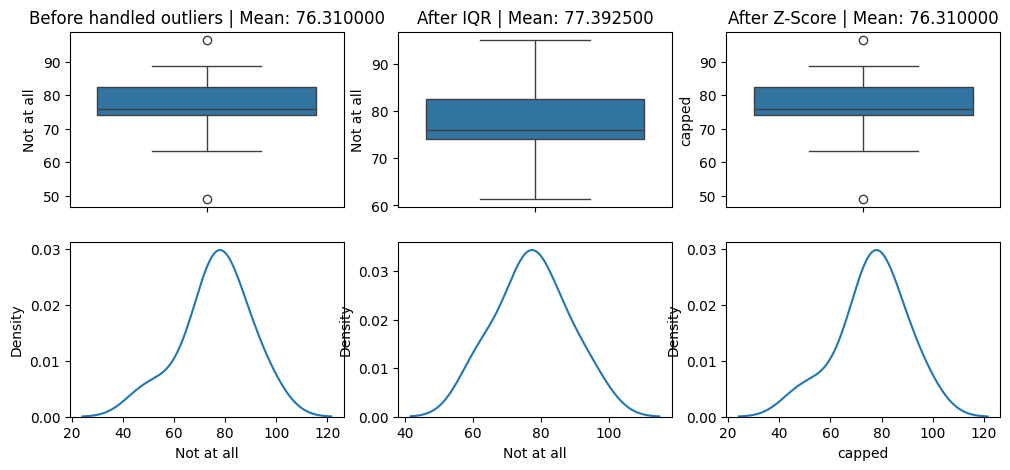

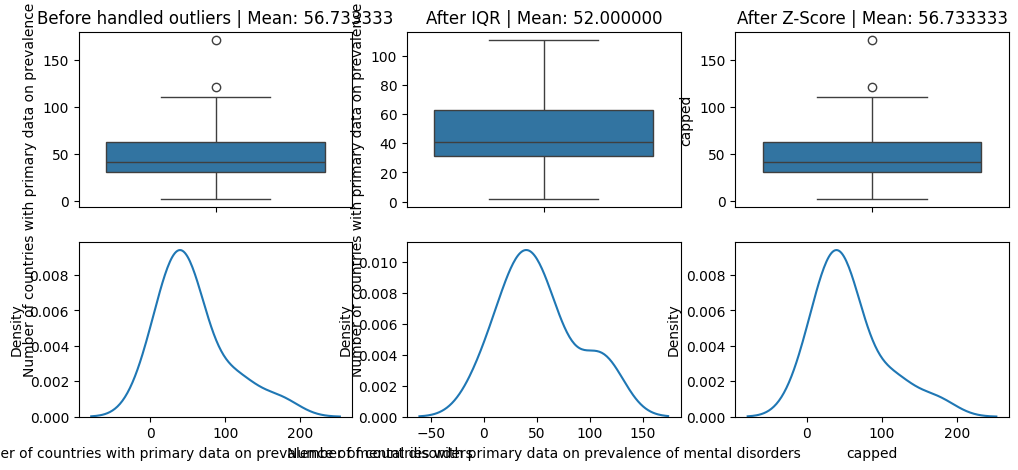

In [33]:
for file in files:
    if file['name'].endswith('.csv'):
        file_name = file['name']
        df_skip = dataframes[file_name].iloc[:, 2:]
        df_skip = df_skip.apply(pd.to_numeric, errors='coerce') #while developing, detect some values are string type, so using this to safely convert them into numeric

        for column in df_skip:

            #draw boxplot and kde before analyte to visualize the outliers
            fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 5))

            axes[0][0].set_title(f'Before handled outliers | Mean: {df_skip[column].mean():.6f}')
            sns.boxplot(y=df_skip[column], ax=axes[0][0])
            sns.kdeplot(df_skip[column], ax=axes[1][0])

            #handle outliers using IQR
            Q1 = df_skip[column].quantile(0.25)
            Q3 = df_skip[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_iqr = df_skip[[column]].copy()
            df_iqr[column]= df_skip[column].clip(lower=lower_bound, upper=upper_bound)

            #draw boxplot after handling outliers
            axes[0][1].set_title(f'After IQR | Mean: {df_iqr[column].mean():.6f}')
            sns.boxplot(y=df_iqr[column], ax=axes[0][1])
            sns.kdeplot(df_iqr[column], ax=axes[1][1])

            # Try z-score method to compare results with IQR method
            df_z = df_skip[[column]].copy()
            df_z['z_score'] = zscore(df_z[column]) 
            df_z['capped'] = df_z[column].where(df_z['z_score'].abs() <= 3) #created capped column to cap values smaller or equal to z-score 3 which is 99.7%

            axes[0][2].set_title(f'After Z-Score | Mean: {df_z[column].mean():.6f}')
            sns.boxplot(y=df_z['capped'].dropna(), ax=axes[0][2])
            sns.kdeplot(df_z['capped'].dropna(), ax=axes[1][2])
            
            plt.show()